In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv('HAM10000_metadata',sep=',')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [3]:
df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [4]:
df.shape

(10015, 8)

In [5]:
dataset_default_path = 'HAM10000_images_part_1'
train_set_path = 'dataset/train'
test_set_path = 'dataset/test'
min_samples = 200
rand_seed = 0

In [6]:
df_nv = df[df.dx=='nv']
df_mel = df[df.dx=='mel']
df_bkl = df[df.dx=='bkl']
df_bcc = df[df.dx=='bcc']


In [7]:
df_nv=df_nv.head(1000)

In [8]:
df_nv.shape

(1000, 8)

In [9]:
data =df_mel.append(df_nv, ignore_index=True)

In [10]:
data1= data.append(df_bkl,ignore_index=True)

df= data1.append(df_bcc,ignore_index=True)

In [11]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest,vidir_modern
1,HAM_0000871,ISIC_0030623,mel,histo,40.0,female,chest,vidir_modern
2,HAM_0000040,ISIC_0027190,mel,histo,80.0,male,upper extremity,rosendahl
3,HAM_0005678,ISIC_0031023,mel,histo,60.0,male,chest,vidir_modern
4,HAM_0005678,ISIC_0028086,mel,histo,60.0,male,chest,vidir_modern


In [12]:
df.shape

(3726, 8)

In [13]:
df.dx.value_counts()

mel    1113
bkl    1099
nv     1000
bcc     514
Name: dx, dtype: int64

<AxesSubplot:xlabel='dx', ylabel='count'>

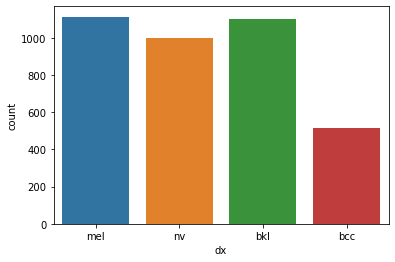

In [16]:
sns.countplot(df['dx'])

In [17]:
df.to_csv('main_data.csv')

In [18]:
df.shape

(3726, 8)

In [22]:
def build_train_test(num_samples=0, train_set_frac=0.75, dataset_path=dataset_default_path,
                     train_path=train_set_path, test_path=test_set_path,
                     overwrite=False):


    if not os.path.isdir(dataset_path):
        dataset_path = dataset_default_path
    
    abs_dataset_path = os.path.abspath(dataset_path)

    if not os.path.isdir(train_path):
        train_path = train_set_path
    
    abs_train_path = os.path.abspath(train_path)
    if overwrite:
        shutil.rmtree(abs_train_path)
        os.mkdir(abs_train_path)

    if not os.path.isdir(test_path):
        test_path = test_set_path
    
    abs_test_path = os.path.abspath(test_path)
    if overwrite:
        shutil.rmtree(abs_test_path)
        os.mkdir(abs_test_path)

        
    ham10000_df = pd.read_csv('main_data.csv',sep=',')
    

    for img_idx in range(ham10000_df['image_id'].count()):
        ham10000_df.at[img_idx, 'image_id'] += '.jpg'

    classes = list(set(ham10000_df.dx))
    num_images = ham10000_df.image_id.count()

    if 0 < num_samples < min_samples:
        ham10000_df = ham10000_df.sample(n=min_samples, random_state=rand_seed)        
    elif num_samples > num_images:
        print('Warning')
        
    elif min_samples <= num_samples <= num_images:
        ham10000_df = ham10000_df.sample(n=num_samples, random_state=rand_seed)


    print(ham10000_df.dx.value_counts())

    if train_set_frac < 0 or train_set_frac > 1.0:
        test_set_frac = 0.75


    train_set, test_set = train_test_split(ham10000_df, train_size=train_set_frac,
                                           random_state=rand_seed,
                                           stratify=ham10000_df.dx)


    train_imgs = list(train_set['image_id'])
    test_imgs = list(test_set['image_id'])

    for img_name in train_imgs:
        src_path = os.path.join(abs_dataset_path, img_name)
        shutil.copy2(src_path, abs_train_path)

    for img_name in test_imgs:
        src_path = os.path.join(abs_dataset_path, img_name)
        shutil.copy2(src_path, abs_test_path)
  
    return train_set, test_set, classes

# Labels description



* basal cell carcinoma (bcc),
* benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl),
* melanoma (mel),
* melanocytic nevi (nv)


In [23]:
train_df, test_df, class_labels = build_train_test(num_samples=3726,
                                                   overwrite=True)

Class labels: ['nv', 'bcc', 'mel', 'bkl']
Number of images in the HAM10000 dataset: 3726
Number of images in the reduced dataset: 3726
Number of images for each class (dataset):
mel    1113
bkl    1099
nv     1000
bcc     514
Name: dx, dtype: int64

Number of images in the training set : 2794
Number of images for each class (training set):
mel    835
bkl    824
nv     750
bcc    385
Name: dx, dtype: int64

Number of images in the test set : 932
Number of images for each class (test set):
mel    278
bkl    275
nv     250
bcc    129
Name: dx, dtype: int64


In [24]:
from keras.preprocessing.image import ImageDataGenerator


dataaug_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

dataaug_val = ImageDataGenerator(rescale=1. / 255)

dataaug_test = ImageDataGenerator(rescale=1. / 255)

train_gen = dataaug_train.flow_from_dataframe(train_df,
                               directory=train_set_path,
                               x_col='image_id',y_col='dx',
                               target_size=(256, 256),
                               batch_size=16,color_mode='rgb',
                               class_mode='categorical',
                               shuffle=True)


val_gen = dataaug_test.flow_from_dataframe(test_df,
                             directory=test_set_path,
                             x_col='image_id',y_col='dx',
                             target_size=(256, 256),color_mode='rgb',
                             batch_size=16,class_mode='categorical',
                             shuffle=False)


test_gen = dataaug_test.flow_from_dataframe(test_df,
                             directory=test_set_path,
                             x_col='image_id',y_col='dx',
                             target_size=(256, 256),
                             batch_size=16,color_mode='rgb',class_mode='categorical',
                             shuffle=False)

Found 2794 validated image filenames belonging to 4 classes.
Found 932 validated image filenames belonging to 4 classes.
Found 932 validated image filenames belonging to 4 classes.


In [25]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , Activation
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau


In [26]:
def plothistory(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])  
    plt.title('Accuracy figure')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of epochs')
    plt.legend(['training', 'validation'])
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss figure')
    plt.ylabel('Loss')
    plt.xlabel('Number of epochs')
    plt.legend(['train', 'validation'])
    plt.show()

# Convolutional Neural network

In [27]:
def models(num_classes):

    model = Sequential()

    # C1 Convolutional Layer
    model.add(Conv2D(filters=32, input_shape=(256, 256, 3), kernel_size=(3, 3),
                     strides=(4, 4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    # Batch Normalization
    model.add(BatchNormalization())

    # C3 Convolutional Layer
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalization
    model.add(BatchNormalization())


    # Flatten
    model.add(Flatten())

    model.add(Dense(512, input_shape=(256 * 256 * 3,)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.3))
    # Batch Normalisation
    model.add(BatchNormalization())


    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [28]:
model= models(4) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 30, 30, 64)        0

In [29]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VAL  =val_gen.n//val_gen.batch_size
STEP_SIZE_TEST =test_gen.n//test_gen.batch_size
num_epochs = 30

In [30]:
history = model.fit(train_gen,steps_per_epoch=STEP_SIZE_TRAIN,epochs=num_epochs,
                    validation_data=val_gen, validation_steps=STEP_SIZE_VAL)

Epoch 1/30
174/174 [==============================] - 88s 501ms/step - loss: 1.2150 - accuracy: 0.5756 - val_loss: 1.6077 - val_accuracy: 0.3815
Epoch 2/30
174/174 [==============================] - 72s 416ms/step - loss: 0.9181 - accuracy: 0.6328 - val_loss: 1.5181 - val_accuracy: 0.3427
Epoch 3/30
174/174 [==============================] - 65s 373ms/step - loss: 0.8194 - accuracy: 0.6667 - val_loss: 0.6840 - val_accuracy: 0.7263
Epoch 4/30
174/174 [==============================] - 63s 364ms/step - loss: 0.8264 - accuracy: 0.6695 - val_loss: 1.4852 - val_accuracy: 0.5043
Epoch 5/30
174/174 [==============================] - 62s 354ms/step - loss: 0.7549 - accuracy: 0.6897 - val_loss: 0.9538 - val_accuracy: 0.6196
Epoch 6/30
174/174 [==============================] - 63s 364ms/step - loss: 0.7460 - accuracy: 0.6904 - val_loss: 0.6127 - val_accuracy: 0.7575
Epoch 7/30
174/174 [==============================] - 61s 349ms/step - loss: 0.7013 - accuracy: 0.7163 - val_loss: 1.3819 - val_ac

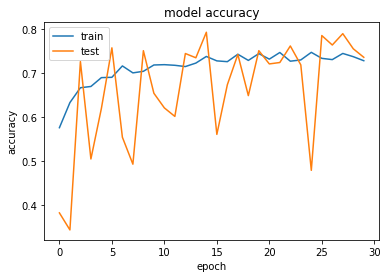

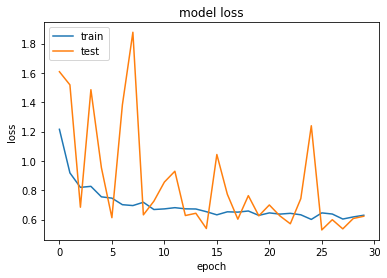

In [32]:
plothistory(history)

In [33]:
# saving the model
from tensorflow.keras import models, layers

models.save_model(model, 'model_cnn.h5')

In [34]:
# evaluating the model on the test datatset
score = model.evaluate(test_gen, steps=STEP_SIZE_TEST) # with test dataset
print(score)

58/58 [==============================] - 7s 116ms/step - loss: 0.6225 - accuracy: 0.7360
[0.6225123405456543, 0.735991358757019]


In [35]:
# model evaluation 

predY=model.predict(test_gen) 
y_pred = np.argmax(predY,axis=1)
y_actual = test_gen.classes

# printing the confusion matrix
cm = confusion_matrix(y_actual, y_pred)
print(cm)

59/59 [==============================] - 7s 120ms/step
[[ 60  39  28   2]
 [ 16 136 110  13]
 [  5  15 247  11]
 [  0   7   1 242]]


In [36]:
# printing the classificaion report
print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.47      0.57       129
           1       0.69      0.49      0.58       275
           2       0.64      0.89      0.74       278
           3       0.90      0.97      0.93       250

    accuracy                           0.73       932
   macro avg       0.74      0.70      0.71       932
weighted avg       0.74      0.73      0.72       932



In [37]:
from sklearn.metrics import precision_score, f1_score,accuracy_score,recall_score,classification_report


accuracy = accuracy_score(test_gen.classes, y_pred)
print("The accuracy of the CNN model is {:.3f}".format(accuracy))

f1 = f1_score(test_gen.classes, y_pred, average='weighted')
print("The f1 score of the CNN model is {:.3f}".format(f1))

recall = recall_score(test_gen.classes, y_pred, average='weighted')
print("The recall of the CNN model is {:.3f}".format(recall))

precision = precision_score(test_gen.classes, y_pred, average='weighted')
print("The precision of the CNN model is {:.3f}".format(precision))



The accuracy of the CNN model is 0.735
The f1 score of the CNN model is 0.722
The recall of the CNN model is 0.735
The precision of the CNN model is 0.739


# ResNet50 v2

In [40]:
from tensorflow.keras.applications import ResNet50V2

base_model=ResNet50V2(input_shape=(256,256,3),weights='imagenet',include_top=False) 

# freeze the base model (for transfer learning)
base_model.trainable = False 

# add Fully-Connected Layers to Model
x=base_model.output
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(128,activation='relu')(x)  # FC layer 
preds=layers.Dense(4,activation='softmax')(x) #final layer with softmax activation

model=models.Model(inputs=base_model.input,outputs=preds)

# printing the summary of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 64, 64, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 64, 64, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 32, 32, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 32, 32, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 16, 16, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 18, 18, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 16, 16, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 16, 16, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 18, 18, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 8, 8, 256)    589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 8, 8, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 8, 8, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 8, 8, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 8, 8, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)  

In [41]:
# compiling the model 
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [42]:
# training the model
history = model.fit(train_gen,steps_per_epoch=STEP_SIZE_TRAIN,epochs=num_epochs,
                    validation_data=val_gen, validation_steps=STEP_SIZE_VAL)

Epoch 1/30
174/174 [==============================] - 153s 862ms/step - loss: 0.8487 - accuracy: 0.6332 - val_loss: 0.7412 - val_accuracy: 0.6940
Epoch 2/30
174/174 [==============================] - 154s 883ms/step - loss: 0.6918 - accuracy: 0.7052 - val_loss: 0.7641 - val_accuracy: 0.6821
Epoch 3/30
174/174 [==============================] - 156s 899ms/step - loss: 0.6362 - accuracy: 0.7282 - val_loss: 0.7086 - val_accuracy: 0.7101
Epoch 4/30
174/174 [==============================] - 162s 930ms/step - loss: 0.6002 - accuracy: 0.7495 - val_loss: 0.6264 - val_accuracy: 0.7511
Epoch 5/30
174/174 [==============================] - 156s 896ms/step - loss: 0.5630 - accuracy: 0.7689 - val_loss: 0.6153 - val_accuracy: 0.7543
Epoch 6/30
174/174 [==============================] - 153s 876ms/step - loss: 0.5520 - accuracy: 0.7682 - val_loss: 0.6177 - val_accuracy: 0.7457
Epoch 7/30
174/174 [==============================] - 174s 998ms/step - loss: 0.5478 - accuracy: 0.7700 - val_loss: 0.5747 -

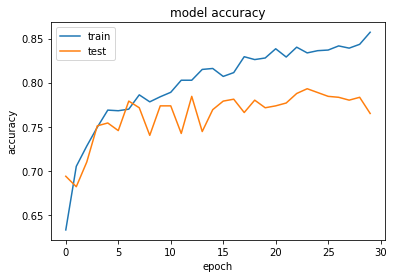

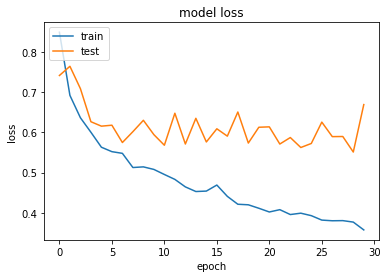

In [49]:
plothistory(history)

In [50]:
models.save_model(model, 'model_resnet50v2.h5')

In [51]:
# evaluating the model on the test datatset
score = model.evaluate(test_gen, steps=STEP_SIZE_TEST) # with test dataset
print(score)

58/58 [==============================] - 41s 712ms/step - loss: 0.6689 - accuracy: 0.7651
[0.6689108610153198, 0.7650862336158752]


In [52]:
# model evaluation 

predY=model.predict(test_gen) 
y_pred = np.argmax(predY,axis=1)
y_actual = test_gen.classes

# printing the confusion matrix
cm = confusion_matrix(y_actual, y_pred)
print(cm)

59/59 [==============================] - 43s 731ms/step
[[ 50  52  26   1]
 [  2 201  55  17]
 [  0  46 226   6]
 [  0   7   8 235]]


In [53]:
# printing the classificaion report
print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.39      0.55       129
           1       0.66      0.73      0.69       275
           2       0.72      0.81      0.76       278
           3       0.91      0.94      0.92       250

    accuracy                           0.76       932
   macro avg       0.81      0.72      0.73       932
weighted avg       0.78      0.76      0.76       932



In [54]:
accuracy = accuracy_score(test_gen.classes, y_pred)
print("The accuracy of the CNN model is {:.3f}".format(accuracy))

f1 = f1_score(test_gen.classes, y_pred, average='weighted')
print("The f1 score of the CNN model is {:.3f}".format(f1))

recall = recall_score(test_gen.classes, y_pred, average='weighted')
print("The recall of the CNN model is {:.3f}".format(recall))

precision = precision_score(test_gen.classes, y_pred, average='weighted')
print("The precision of the CNN model is {:.3f}".format(precision))

The accuracy of the CNN model is 0.764
The f1 score of the CNN model is 0.756
The recall of the CNN model is 0.764
The precision of the CNN model is 0.784
